In [5]:
import numpy as np
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/github/RoboSkin/Code/NewRigExperiments/texture-tactip/"


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

In [11]:
data_ = np.load(datapath+"X_data_presstip_freq.npz") #load data
X=None
for array_name in data_:
    X=data_[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data_ = np.load(datapath+"y_data_presstip_freq.npz") #load data
y=None
for array_name in data_:
    y=data_[array_name]
print(X.shape,y.shape)
cutoff_frequency = 3.3  # Define your cutoff frequency
sampling_rate = 50.0    # Define your sampling rate
filter_order = 5       # Order of the filter

# Assuming dataset is of shape (n, t, s)
def apply_filter_to_dataset(dataset, cutoff, fs, order=5):
    n, t, s = dataset.shape
    filtered_data = np.zeros_like(dataset)

    # Apply the filter to each sensor for each item
    for i in range(n):
        for j in range(s):
            filtered_data[i, :, j] = butter_lowpass_filter(dataset[i, :, j], cutoff, fs, order)

    return filtered_data

# Example usage
# dataset = np.random.randn(n, t, s)  # Example dataset (replace with your actual data)
#filtered_dataset = apply_filter_to_dataset(X, cutoff_frequency, sampling_rate, filter_order)
#X=filtered_dataset


(100, 20, 16) (100,)


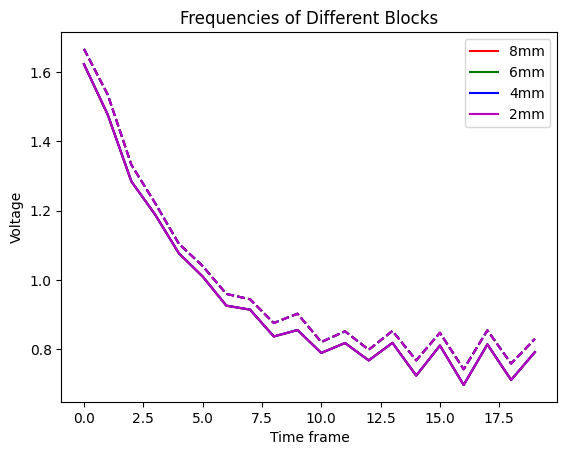

In [22]:
mil8=X[np.where(y==0)]
mil6=X[np.where(y==0)]
mil4=X[np.where(y==0)]
mil2=X[np.where(y==0)]

plt.plot(np.average(mil8[:,:,8],axis=0),c="r",label="8mm")
plt.plot(np.average(mil8[:,:,8],axis=0)+np.std(X[:,:,8],axis=0),"--",c="r")

plt.plot(np.average(mil6[:,:,8],axis=0),c="g",label="6mm")
plt.plot(np.average(mil6[:,:,8],axis=0)+np.std(X[:,:,8],axis=0),"--",c="g")

plt.plot(np.average(mil4[:,:,8],axis=0),c="b",label="4mm")
plt.plot(np.average(mil4[:,:,8],axis=0)+np.std(X[:,:,8],axis=0),"--",c="b")

plt.plot(np.average(mil2[:,:,8],axis=0),c="m",label="2mm")
plt.plot(np.average(mil2[:,:,8],axis=0)+np.std(X[:,:,8],axis=0),"--",c="m")
plt.title("Frequencies of Different Blocks")
plt.legend(loc="upper right")
plt.ylabel("Voltage")
plt.xlabel("Time frame")
plt.show()